# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
## Mapping Analysis

Mark Bauer

# Goal
In this notebook, we analyze NYC's 311 Street Flooding Complaints data from 2010 to 2020. Specifically, I attempt to answer the following questions:

- What is the distribution of street flooding complaints by neighborhood?
- How have street flooding complaints changed over time?

# Main Python Libraries:
[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

[GeoPandas](https://geopandas.org/index.html) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

[Matplotlib](https://matplotlib.org/3.1.1/index.html#) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

[Seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

# Datasets

## 311 Service Requests from 2010 to Present  
Website: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311's data dictionary can be found in the data folder. 



![311](images/nyc-311-screenshot.png)

## Neighborhood Tabulation Areas (NTA)  
Website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

![nta](images/nyc-nta-screenshot.png)

# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.  
Documention for installing watermark: https://github.com/rasbt/watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.22.4
pandas    : 1.4.2
geopandas : 0.9.0
geoplot   : 0.5.1
fiona     : 1.8.21
matplotlib: 3.5.2
seaborn   : 0.11.2



# Loading Data

## NYC 311 Street Flooding Complaints

In [3]:
# list items in data folder
%ls data/

README.md                       street-flooding-query.csv
street-flooding-complaints.csv  streets-clipped.gpkg


In [4]:
# read data as a dataframe
df = pd.read_csv('data/street-flooding-complaints.csv', low_memory=False)

# previewing first five rows in data
print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (24817, 27)


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,community_board,bbl,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_borough,latitude,longitude,location
0,45283755,2019-12-31T22:42:00.000,2020-01-07T11:07:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,02 STATEN ISLAND,5.037950e+09,STATEN ISLAND,958363.0,148793.0,ONLINE,STATEN ISLAND,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':..."
1,45283863,2019-12-31T17:34:00.000,2020-01-01T15:45:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10312.0,NaN,NaN,...,03 STATEN ISLAND,NaN,STATEN ISLAND,937878.0,143517.0,PHONE,STATEN ISLAND,40.560476,-74.166889,"{'latitude': '40.56047555908232', 'longitude':..."
2,45279400,2019-12-31T16:11:00.000,2020-01-08T10:10:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10305.0,753 QUINCY AVENUE,QUINCY AVENUE,...,02 STATEN ISLAND,5.038260e+09,STATEN ISLAND,960864.0,149333.0,PHONE,STATEN ISLAND,40.576530,-74.084185,"{'latitude': '40.576529751013474', 'longitude'..."
3,45277773,2019-12-31T15:42:00.000,2020-01-01T05:25:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11379.0,61-21 70 STREET,70 STREET,...,05 QUEENS,4.029270e+09,QUEENS,1015410.0,201741.0,PHONE,QUEENS,40.720354,-73.887589,"{'latitude': '40.72035428730757', 'longitude':..."
4,45282532,2019-12-31T12:18:00.000,2019-12-31T14:15:00.000,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),11375.0,NaN,NaN,...,06 QUEENS,NaN,QUEENS,1027498.0,202160.0,PHONE,QUEENS,40.721454,-73.843978,"{'latitude': '40.721453503515995', 'longitude'..."


In [5]:
# printing the column names, non-null counts, and data types of our columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      24817 non-null  int64  
 1   created_date                    24817 non-null  object 
 2   closed_date                     24815 non-null  object 
 3   agency                          24817 non-null  object 
 4   agency_name                     24817 non-null  object 
 5   complaint_type                  24817 non-null  object 
 6   descriptor                      24817 non-null  object 
 7   incident_zip                    24817 non-null  float64
 8   incident_address                16002 non-null  object 
 9   street_name                     16002 non-null  object 
 10  cross_street_1                  21821 non-null  object 
 11  cross_street_2                  21816 non-null  object 
 12  address_type                    

# Data Sources

## NYC Boroughs

In [6]:
# importing borough boundaries
path = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
borough_gdf = gpd.read_file(path)
borough_gdf = borough_gdf.to_crs(2263)

# previewing first five rows in data
print('shape of data: {}'.format(borough_gdf.shape))
borough_gdf.head()

shape of data: (5, 5)


,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623621e+09,325917.353950,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,2.0,Bronx,1.187175e+09,463179.772813,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."
2,4.0,Queens,3.041419e+09,888199.730955,"MULTIPOLYGON (((1032452.015 154469.237, 103245..."
3,1.0,Manhattan,6.365205e+08,357713.308660,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,3.0,Brooklyn,1.934138e+09,728148.532410,"MULTIPOLYGON (((1022227.320 152028.146, 102207..."


In [7]:
borough_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   boro_code   5 non-null      float64 
 1   boro_name   5 non-null      object  
 2   shape_area  5 non-null      float64 
 3   shape_leng  5 non-null      float64 
 4   geometry    5 non-null      geometry
dtypes: float64(3), geometry(1), object(1)
memory usage: 328.0+ bytes


## Neighborhood Tabulation Areas (NTAs)

In [8]:
# importing nta boundaries
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_gdf = gpd.read_file(url)
nta_gdf = nta_gdf.to_crs(epsg=2263)

# previewing first five rows in data
print('shape of data: {}'.format(nta_gdf.shape[0]))
nta_gdf.head()

shape of data: 195


,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,QN08,77412747.847,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308..."
1,BX28,25666124.5948,005,Van Cortlandt Village,21945.719299,Bronx,2,"MULTIPOLYGON (((1015481.837 261490.578, 101548..."
2,QN55,82461393.7368,081,South Ozone Park,36708.1693055,Queens,4,"MULTIPOLYGON (((1038120.503 188147.096, 103819..."
3,BK50,82089678.6389,047,Canarsie,43703.6096661,Brooklyn,3,"MULTIPOLYGON (((1015236.151 174910.303, 101523..."
4,BX41,14716710.7402,005,Mount Hope,18937.247819,Bronx,2,"MULTIPOLYGON (((1013128.525 250637.931, 101284..."


In [9]:
nta_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      195 non-null    object  
 1   shape_area   195 non-null    object  
 2   county_fips  195 non-null    object  
 3   ntaname      195 non-null    object  
 4   shape_leng   195 non-null    object  
 5   boro_name    195 non-null    object  
 6   boro_code    195 non-null    object  
 7   geometry     195 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 12.3+ KB


# Data Wrangling

In [10]:
# format datetime columns
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])
df['year'] = df['created_date'].dt.year

# examine columns
df.loc[:, ['created_date', 'closed_date', 'year']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24817 entries, 0 to 24816
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_date  24817 non-null  datetime64[ns]
 1   closed_date   24815 non-null  datetime64[ns]
 2   year          24817 non-null  int64         
dtypes: datetime64[ns](2), int64(1)
memory usage: 581.8 KB


In [11]:
# create new columns in nta dataframe
nta_gdf['ntaname_boro'] = nta_gdf['ntaname'] + ', ' + nta_gdf['boro_name']
nta_gdf['shape_area'] = nta_gdf['shape_area'].astype(float)
nta_gdf['shape_leng'] = nta_gdf['shape_leng'].astype(float)
nta_gdf['shape_area_sq_mi'] = nta_gdf['shape_area'] / 27878400

# examine new columns
nta_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ntacode           195 non-null    object  
 1   shape_area        195 non-null    float64 
 2   county_fips       195 non-null    object  
 3   ntaname           195 non-null    object  
 4   shape_leng        195 non-null    float64 
 5   boro_name         195 non-null    object  
 6   boro_code         195 non-null    object  
 7   geometry          195 non-null    geometry
 8   ntaname_boro      195 non-null    object  
 9   shape_area_sq_mi  195 non-null    float64 
dtypes: float64(3), geometry(1), object(6)
memory usage: 15.4+ KB


In [12]:
# generate x, y points to geometry

crs = 2263
geometry = gpd.points_from_xy(
    df['x_coordinate_state_plane'],
    df['y_coordinate_state_plane']
)

gdf = gpd.GeoDataFrame(
    df,
    geometry=geometry,
    crs=crs
)

# preview data
print('shape of data: {}'.format(gdf.shape))
gdf.iloc[:5, -5:]

/Users/markbauer/opt/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


shape of data: (24817, 29)


,latitude,longitude,location,year,geometry
0,40.575041,-74.093186,"{'latitude': '40.57504060779978', 'longitude':...",2019,POINT (958363.000 148793.000)
1,40.560476,-74.166889,"{'latitude': '40.56047555908232', 'longitude':...",2019,POINT (937878.000 143517.000)
2,40.576530,-74.084185,"{'latitude': '40.576529751013474', 'longitude'...",2019,POINT (960864.000 149333.000)
3,40.720354,-73.887589,"{'latitude': '40.72035428730757', 'longitude':...",2019,POINT (1015410.000 201741.000)
4,40.721454,-73.843978,"{'latitude': '40.721453503515995', 'longitude'...",2019,POINT (1027498.000 202160.000)


In [13]:
# confirm crs
gdf.crs

<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

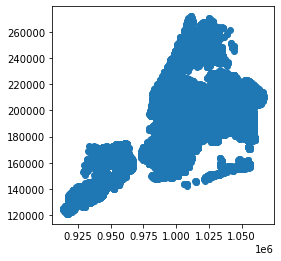

In [14]:
# sanity check map
gdf.plot()

## Spatial Join Complaint Points to Neighborhood Tabulation Areas (NTAs)

In [15]:
gdf_merged = gpd.sjoin(
    gdf,
    nta_gdf,
    how="inner",
    op='within'
)

gdf_merged = (
    gdf_merged
    .drop(columns=['index_right'])
    .reset_index(drop=True)
)

# sanity checks
print('shape of data: {:,}'.format(gdf_merged.shape[0]))
print('count dropped rows: {}'.format(gdf.shape[0] - gdf_merged.shape[0]))
print('unique_key unique: {}.'.format(gdf_merged['unique_key'].is_unique))
print('crs: {}'.format(gdf_merged.crs))

# preview data
gdf_merged.head()

shape of data: 24,814
count dropped rows: 3
unique_key unique: True.
crs: epsg:2263


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,geometry,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,ntaname_boro,shape_area_sq_mi
0,45283755,2019-12-31 22:42:00,2020-01-07 11:07:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
1,45279697,2019-12-31 07:10:00,2019-12-31 09:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
2,45196140,2019-12-18 15:58:00,2019-12-20 09:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,POINT (951437.000 148868.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
3,45188340,2019-12-18 10:16:00,2019-12-20 09:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,POINT (954138.000 151251.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
4,45188337,2019-12-18 09:30:00,2019-12-18 19:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931


In [16]:
gdf_merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24814 entries, 0 to 24813
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      24814 non-null  int64         
 1   created_date                    24814 non-null  datetime64[ns]
 2   closed_date                     24812 non-null  datetime64[ns]
 3   agency                          24814 non-null  object        
 4   agency_name                     24814 non-null  object        
 5   complaint_type                  24814 non-null  object        
 6   descriptor                      24814 non-null  object        
 7   incident_zip                    24814 non-null  float64       
 8   incident_address                16002 non-null  object        
 9   street_name                     16002 non-null  object        
 10  cross_street_1                  21821 non-null  object        

In [17]:
# two borough columns, check borough comparison between complaint and nta
condition = (gdf_merged['borough'].str.title() != gdf_merged['boro_name'].str.title())
count = gdf_merged.loc[condition].shape[0]

print("count of borough names that don't reconcile: {:,}".format(count))

count of borough names that don't reconcile: 95


In [18]:
# drop borough column from 311 dataset, using this pandas style so we can run this cell again if needed
criteria = gdf_merged.columns.isin(['borough'])
gdf_merged = gdf_merged.loc[:, gdf_merged.columns[~criteria]]

print('shape of data: {}\n'.format(gdf_merged.shape))
gdf_merged.info()

shape of data: (24814, 37)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24814 entries, 0 to 24813
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      24814 non-null  int64         
 1   created_date                    24814 non-null  datetime64[ns]
 2   closed_date                     24812 non-null  datetime64[ns]
 3   agency                          24814 non-null  object        
 4   agency_name                     24814 non-null  object        
 5   complaint_type                  24814 non-null  object        
 6   descriptor                      24814 non-null  object        
 7   incident_zip                    24814 non-null  float64       
 8   incident_address                16002 non-null  object        
 9   street_name                     16002 non-null  object        
 10  cross_street_1                  21

# Mapping

## Hexbins

In [19]:
# identify max bounds of hexbin gridsize=30
hb = plt.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=30,
    mincnt=1,
)

plt.close()
print('max value of array: {}'.format(hb.get_array().max()))

max value of array: 423.0


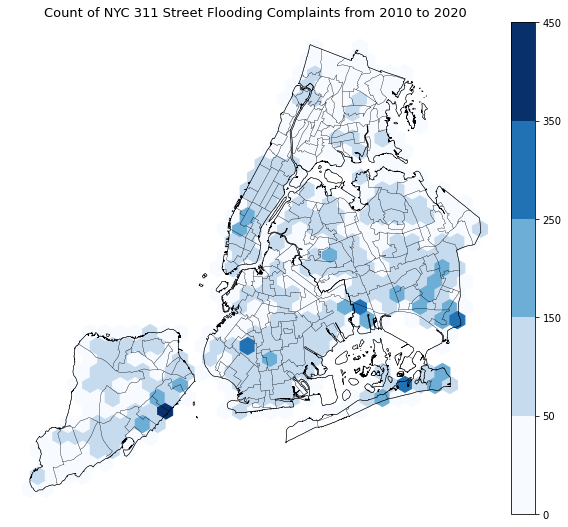

In [20]:
# 30 hexagons in the x-direction
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, 50, 150, 250, 350, 450], cmap.N)

hb = ax.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=30,
    mincnt=1,
    cmap=cmap,
    norm=norm,
    zorder=0,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax
)

plt.colorbar(hb, cax=cax)

ax.set_title("Count of NYC 311 Street Flooding \
Complaints from 2010 to 2020", fontsize=13)
ax.axis('off')
plt.tight_layout()

In [21]:
# identify max bounds of hexbin gridsize=50
hb = plt.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=50,
    mincnt=1,
)

plt.close()
print('max value of array: {}'.format(hb.get_array().max()))

max value of array: 318.0


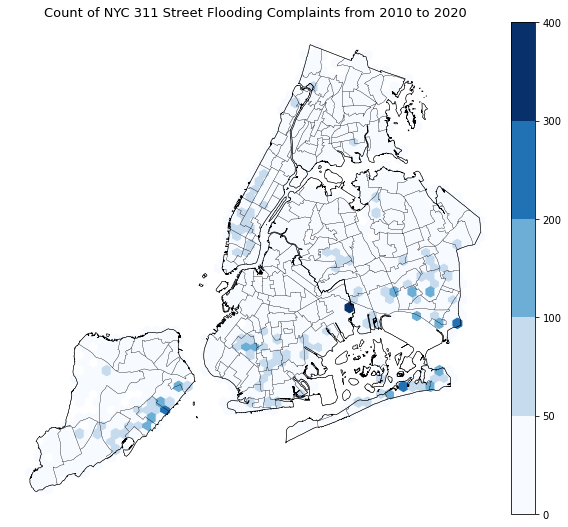

In [22]:
# 30 hexagons in the x-direction
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues

# selected boundaries by trial and error
norm = mpl.colors.BoundaryNorm([0, 50, 100, 200, 300, 400], cmap.N)

hb = ax.hexbin(
    gdf_merged['x_coordinate_state_plane'], 
    gdf_merged['y_coordinate_state_plane'], 
    gridsize=50,
    mincnt=1,
    cmap=cmap,
    norm=norm,
    zorder=0,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax
)

plt.colorbar(hb, cax=cax)

ax.set_title("Count of NYC 311 Street Flooding Complaints from 2010 to 2020", fontsize=13)
ax.axis('off')
plt.tight_layout()

### By Borough

In [23]:
gdf_merged.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,geometry,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,ntaname_boro,shape_area_sq_mi
0,45283755,2019-12-31 22:42:00,2020-01-07 11:07:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
1,45279697,2019-12-31 07:10:00,2019-12-31 09:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
2,45196140,2019-12-18 15:58:00,2019-12-20 09:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,POINT (951437.000 148868.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
3,45188340,2019-12-18 10:16:00,2019-12-20 09:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,POINT (954138.000 151251.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
4,45188337,2019-12-18 09:30:00,2019-12-18 19:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931


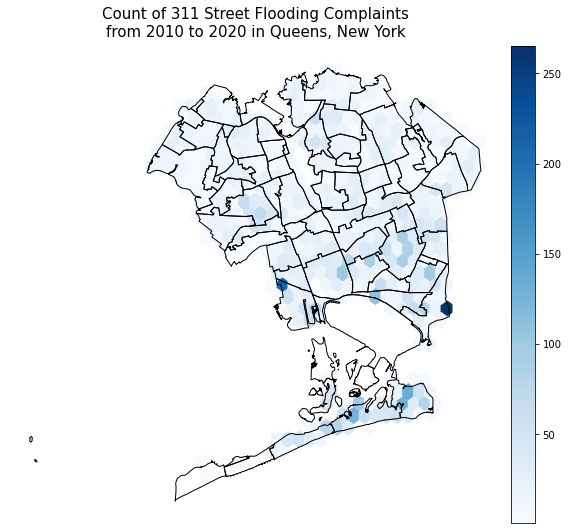

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(
    gdf_merged[gdf_merged['boro_name'] == 'Queens']['x_coordinate_state_plane'], 
    gdf_merged[gdf_merged['boro_name'] == 'Queens']['y_coordinate_state_plane'], 
    gridsize=30, mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf.boro_name == 'Queens']
 .plot(facecolor="none", 
       edgecolor="black", 
       ax=ax)
)

ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\n\
from 2010 to 2020 in Queens, New York', fontsize=15, pad=10)
plt.tight_layout()

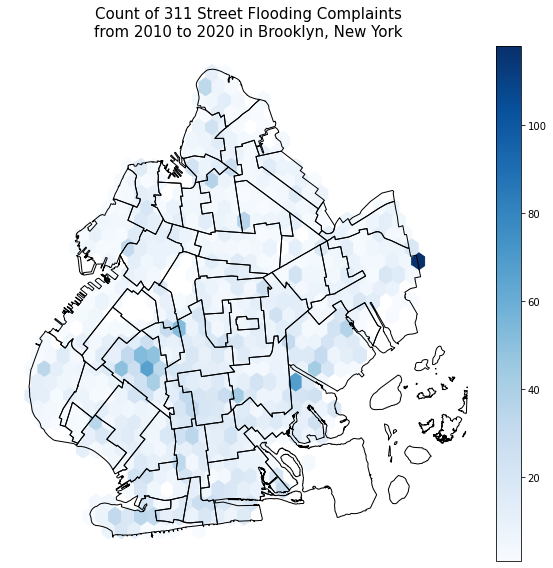

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(
    gdf_merged.loc[gdf_merged['boro_name'] == 'Brooklyn']['x_coordinate_state_plane'], 
    gdf_merged.loc[gdf_merged['boro_name'] == 'Brooklyn']['y_coordinate_state_plane'], 
    gridsize=30, mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf.boro_name == 'Brooklyn']
 .plot(facecolor="none", 
       edgecolor="black", 
       ax=ax)
)
 
ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 \
in Brooklyn, New York', fontsize=15, pad=10)
plt.tight_layout()

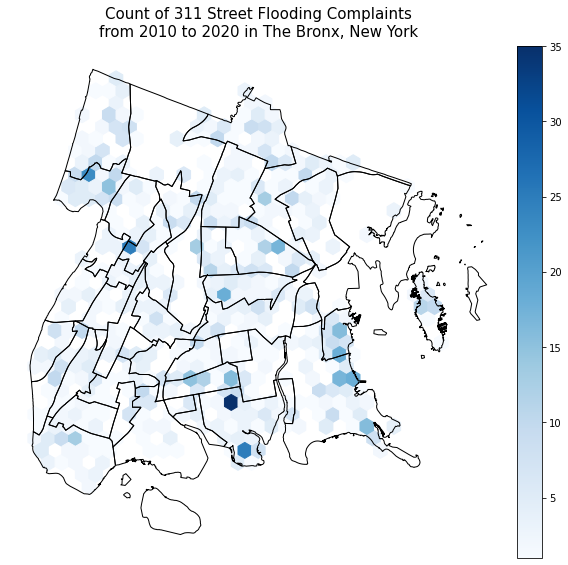

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(gdf_merged[gdf_merged['boro_name'] == 'Bronx']['x_coordinate_state_plane'], 
               gdf_merged[gdf_merged['boro_name'] == 'Bronx']['y_coordinate_state_plane'], 
               gridsize=30, mincnt=1,
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf.boro_name == 'Bronx']
 .plot(facecolor="none", 
       edgecolor="black", 
       ax=ax)
)

ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\n\
from 2010 to 2020 in The Bronx, New York', fontsize=15, pad=10)
plt.tight_layout()

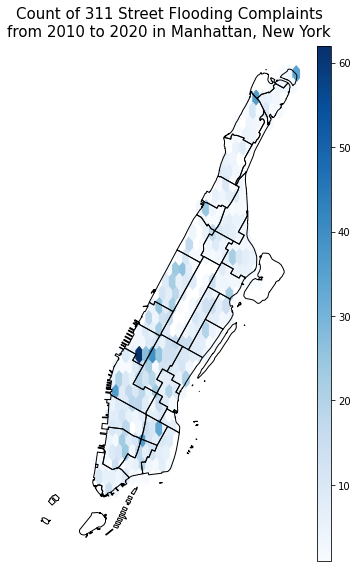

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(
    gdf_merged[gdf_merged['boro_name'] == 'Manhattan']['x_coordinate_state_plane'], 
    gdf_merged[gdf_merged['boro_name'] == 'Manhattan']['y_coordinate_state_plane'], 
    gridsize=30, mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf.boro_name == 'Manhattan']
 .plot(facecolor="none", 
       edgecolor="black", 
       ax=ax)
)

ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\n\
from 2010 to 2020 in Manhattan, New York', fontsize=15, pad=10)
plt.tight_layout()

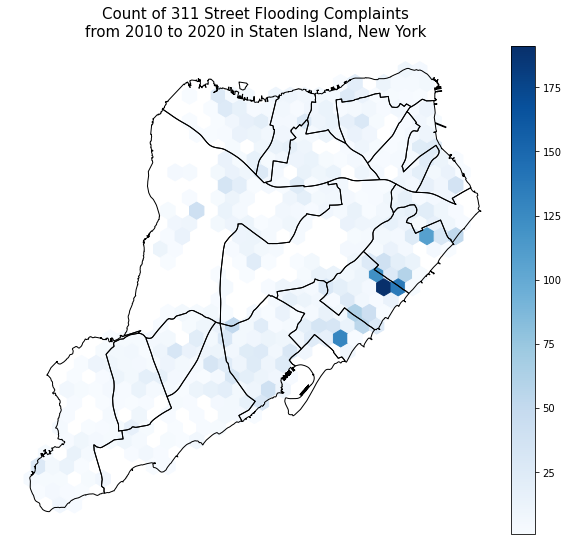

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))

hb = ax.hexbin(
    gdf_merged[gdf_merged['boro_name'] == 'Staten Island']['x_coordinate_state_plane'], 
    gdf_merged[gdf_merged['boro_name'] == 'Staten Island']['y_coordinate_state_plane'], 
    gridsize=30, mincnt=1,
    cmap='Blues'
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

(nta_gdf
 .loc[nta_gdf.boro_name == 'Staten Island']
 .plot(facecolor="none", 
       edgecolor="black", 
       ax=ax)
)

ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\n\
from 2010 to 2020 in Staten Island, New York', fontsize=15, pad=10)
plt.tight_layout()

## Counts by Neighborhood Tabulation Areas (NTA)

In [29]:
gdf_merged.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24814 entries, 0 to 24813
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      24814 non-null  int64         
 1   created_date                    24814 non-null  datetime64[ns]
 2   closed_date                     24812 non-null  datetime64[ns]
 3   agency                          24814 non-null  object        
 4   agency_name                     24814 non-null  object        
 5   complaint_type                  24814 non-null  object        
 6   descriptor                      24814 non-null  object        
 7   incident_zip                    24814 non-null  float64       
 8   incident_address                16002 non-null  object        
 9   street_name                     16002 non-null  object        
 10  cross_street_1                  21821 non-null  object        

In [30]:
# group complaints by NTA
grouped_gdf = (
    gdf_merged
    .groupby(by='ntaname_boro')['unique_key']
    .count()
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

# merge nta complaint counts with nta shapefile
nta_gdf_counts = nta_gdf.merge(
    grouped_gdf,
    on='ntaname_boro'
)

nta_gdf_counts['count_sq_mi'] = (
    nta_gdf_counts['count'] / nta_gdf_counts['shape_area_sq_mi']).round(0).astype(int)

print('shape of data: {}\n'.format(nta_gdf_counts.shape))
nta_gdf_counts.head()

shape of data: (194, 12)



,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,ntaname_boro,shape_area_sq_mi,count,count_sq_mi
0,QN08,7.741275e+07,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308...","St. Albans, Queens",2.776800,550,198
1,BX28,2.566612e+07,005,Van Cortlandt Village,21945.719299,Bronx,2,"MULTIPOLYGON (((1015481.837 261490.578, 101548...","Van Cortlandt Village, Bronx",0.920646,44,48
2,QN55,8.246139e+07,081,South Ozone Park,36708.169305,Queens,4,"MULTIPOLYGON (((1038120.503 188147.096, 103819...","South Ozone Park, Queens",2.957895,372,126
3,BK50,8.208968e+07,047,Canarsie,43703.609666,Brooklyn,3,"MULTIPOLYGON (((1015236.151 174910.303, 101523...","Canarsie, Brooklyn",2.944562,381,129
4,BX41,1.471671e+07,005,Mount Hope,18937.247819,Bronx,2,"MULTIPOLYGON (((1013128.525 250637.931, 101284...","Mount Hope, Bronx",0.527889,18,34


In [31]:
# summary stats of nta counts
nta_gdf_counts.loc[:, ['count', 'count_sq_mi']].describe()

,count,count_sq_mi
count,194.000000,194.000000
mean,127.907216,90.721649
std,126.874797,58.374038
min,5.000000,1.000000
25%,48.250000,53.250000
50%,86.500000,77.000000
75%,157.750000,117.250000
max,690.000000,347.000000


**Table xx:**

In [32]:
# preview count_sq_mi sort desc
(nta_gdf_counts.loc[:, ['ntaname_boro', 'shape_area_sq_mi', 'count', 'count_sq_mi']]
 .sort_values(by='count_sq_mi', ascending=False)
 .head(20)
 .loc[:, ['ntaname_boro', 'shape_area_sq_mi', 'count', 'count_sq_mi']]
 .round({'shape_area_sq_mi': 3})
 .rename(columns={'shape_area_sq_mi':'area_sq_mi'})
 .reset_index(drop=True)
 .set_index([pd.Series(range(1, 21))])
) 

,ntaname_boro,area_sq_mi,count,count_sq_mi
1,"New Dorp-Midland Beach, Staten Island",1.989,690,347
2,"Hammels-Arverne-Edgemere, Queens",2.220,662,298
3,"Far Rockaway-Bayswater, Queens",1.944,520,267
4,"Borough Park, Brooklyn",1.937,501,259
5,"Springfield Gardens South-Brookville, Queens",1.553,389,251
6,"Lindenwood-Howard Beach, Queens",2.315,566,244
7,"East Village, Manhattan",0.391,90,230
8,"Midtown-Midtown South, Manhattan",1.083,233,215
9,"Old Town-Dongan Hills-South Beach, Staten Island",2.404,500,208
10,"Lincoln Square, Manhattan",0.567,118,208


**Table xx:**

In [33]:
# preview count sort desc
(nta_gdf_counts.loc[:, ['ntaname_boro', 'shape_area_sq_mi', 'count', 'count_sq_mi']]
 .sort_values(by='count', ascending=False)
 .head(20)
 .loc[:, ['ntaname_boro', 'shape_area_sq_mi', 'count', 'count_sq_mi']]
 .round({'shape_area_sq_mi': 3})
 .rename(columns={'shape_area_sq_mi':'area_sq_mi'})
 .reset_index(drop=True)
 .set_index([pd.Series(range(1, 21))])
) 

,ntaname_boro,area_sq_mi,count,count_sq_mi
1,"New Dorp-Midland Beach, Staten Island",1.989,690,347
2,"Hammels-Arverne-Edgemere, Queens",2.220,662,298
3,"Lindenwood-Howard Beach, Queens",2.315,566,244
4,"St. Albans, Queens",2.777,550,198
5,"Far Rockaway-Bayswater, Queens",1.944,520,267
6,"Borough Park, Brooklyn",1.937,501,259
7,"Old Town-Dongan Hills-South Beach, Staten Island",2.404,500,208
8,"Great Kills, Staten Island",3.214,484,151
9,"Rosedale, Queens",2.209,439,199
10,"Oakwood-Oakwood Beach, Staten Island",2.006,396,197


**Table xx:**

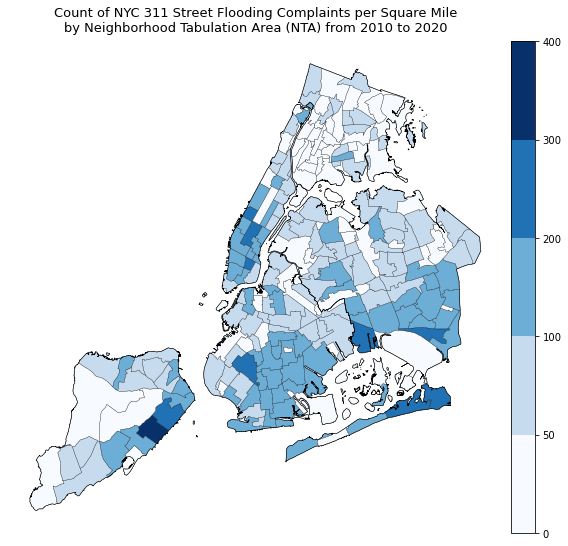

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, 50, 100, 200, 300, 400], cmap.N)

nta_gdf_counts.plot(
    column='count_sq_mi', 
    cmap=cmap,
    ax=ax, 
    legend=True,
    cax=cax,
    norm=norm,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax,
    zorder=1
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax,
    zorder=2
)

title = 'Count of NYC 311 Street Flooding Complaints per Square Mile\n\
by Neighborhood Tabulation Area (NTA) from 2010 to 2020'
ax.set_title(title, fontsize=13, pad=10)

ax.axis('off')
plt.tight_layout()
plt.savefig('figures/cover-photo.png', dpi=250)

## Counts by Neighborhood Tabulation Areas (NTA) by Year

In [35]:
year_nta = (
    gdf_merged
    .groupby(by=['year', 'ntaname_boro'])['unique_key']
    .count()
    .reset_index()
    .rename(columns={"unique_key": "count"})
)

year_nta = nta_gdf.merge(
    year_nta, 
    on='ntaname_boro',
    how='left'
)

year_nta = (
    year_nta
    .loc[~year_nta['year'].isnull()]
    .astype({'year':'int'})
    .reset_index(drop=True)
)

year_nta['count'] = year_nta['count'].fillna(0).astype(int)
year_nta['shape_area_sq_mi'] = year_nta['shape_area_sq_mi'].fillna(0)
year_nta['count_sq_mi'] = (year_nta['count'] / (year_nta['shape_area_sq_mi']).replace(0, np.nan)).fillna(0).round(3)

print('shape of data: {}\n'.format(year_nta.shape))
year_nta.head()

shape of data: (1843, 13)



,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,ntaname_boro,shape_area_sq_mi,year,count,count_sq_mi
0,QN08,7.741275e+07,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308...","St. Albans, Queens",2.7768,2010,52,18.727
1,QN08,7.741275e+07,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308...","St. Albans, Queens",2.7768,2011,57,20.527
2,QN08,7.741275e+07,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308...","St. Albans, Queens",2.7768,2012,70,25.209
3,QN08,7.741275e+07,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308...","St. Albans, Queens",2.7768,2013,56,20.167
4,QN08,7.741275e+07,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308...","St. Albans, Queens",2.7768,2014,41,14.765


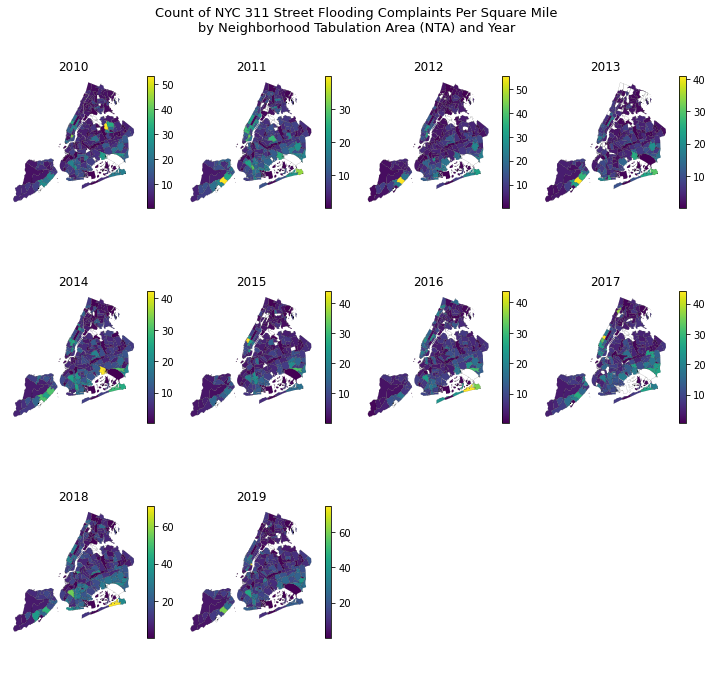

In [36]:
fig, axes = plt.subplots(3, 4, figsize=(10, 10))
for ax, year in zip(axes.flat, year_nta['year'].unique()):
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    (year_nta
     .loc[year_nta['year'] == year]
     .plot(
         column='count_sq_mi', 
         cmap='viridis',
         legend=True,
         ax=ax, 
         cax=cax)
    )
    
    nta_gdf.plot(
        facecolor="none",
        edgecolor="black",
        linewidth=.09,
        ax=ax
    )
    
    ax.set_title(str(year), fontsize=12)
    ax.axis('off')

axes[2,2].set_axis_off()
axes[2,3].set_axis_off()

fig.suptitle('Count of NYC 311 Street Flooding Complaints Per Square Mile\n\
by Neighborhood Tabulation Area (NTA) and Year', y=.96, fontsize=13) 
fig.tight_layout()   


## Timedelta of Complaints Response Time

In [37]:
gdf_merged.head()

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,incident_zip,incident_address,street_name,...,geometry,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,ntaname_boro,shape_area_sq_mi
0,45283755,2019-12-31 22:42:00,2020-01-07 11:07:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
1,45279697,2019-12-31 07:10:00,2019-12-31 09:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
2,45196140,2019-12-18 15:58:00,2019-12-20 09:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,101 3 STREET,3 STREET,...,POINT (951437.000 148868.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
3,45188340,2019-12-18 10:16:00,2019-12-20 09:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,15 LISBON PLACE,LISBON PLACE,...,POINT (954138.000 151251.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931
4,45188337,2019-12-18 09:30:00,2019-12-18 19:30:00,DEP,Department of Environmental Protection,Sewer,Street Flooding (SJ),10306.0,131 GRIMSBY STREET,GRIMSBY STREET,...,POINT (958363.000 148793.000),SI45,5.544820e+07,085,New Dorp-Midland Beach,34369.889272,Staten Island,5,"New Dorp-Midland Beach, Staten Island",1.988931


In [38]:
gdf_merged['complaint_duration'] = gdf_merged['closed_date'] - gdf_merged['created_date']

gdf_merged.loc[:, ['created_date', 'closed_date', 'complaint_duration']].head(10)

,created_date,closed_date,complaint_duration
0,2019-12-31 22:42:00,2020-01-07 11:07:00,6 days 12:25:00
1,2019-12-31 07:10:00,2019-12-31 09:30:00,0 days 02:20:00
2,2019-12-18 15:58:00,2019-12-20 09:30:00,1 days 17:32:00
3,2019-12-18 10:16:00,2019-12-20 09:30:00,1 days 23:14:00
4,2019-12-18 09:30:00,2019-12-18 19:30:00,0 days 10:00:00
5,2019-12-18 09:02:00,2019-12-18 20:30:00,0 days 11:28:00
6,2019-12-17 14:25:00,2019-12-25 14:46:00,8 days 00:21:00
7,2019-12-17 13:45:00,2019-12-18 09:30:00,0 days 19:45:00
8,2019-12-17 12:12:00,2019-12-18 09:30:00,0 days 21:18:00
9,2019-12-17 11:41:00,2019-12-18 09:30:00,0 days 21:49:00


In [39]:
gdf_merged['complaint_duration_days'] = gdf_merged['complaint_duration'].dt.days
gdf_merged['complaint_duration_seconds'] = gdf_merged['complaint_duration'].dt.seconds
gdf_merged['complaint_duration_hours'] = gdf_merged['complaint_duration'] / pd.Timedelta(hours=1)

gdf_merged.loc[:, ['complaint_duration_days', 'complaint_duration_hours']].describe()

,complaint_duration_days,complaint_duration_hours
count,24812.00000,24812.000000
mean,2.22743,63.396147
std,12.84321,308.849567
min,0.00000,0.000000
25%,0.00000,3.083333
50%,0.00000,17.450000
75%,1.00000,43.400000
max,569.00000,13672.766667


In [40]:
grouped_gdf = (
    gdf_merged
    .groupby('ntaname_boro')['complaint_duration_hours']
    .median()
    .reset_index()
)

nta_shape_time = nta_gdf.merge(
    grouped_gdf, 
    left_on='ntaname_boro', 
    right_on='ntaname_boro'
)

nta_shape_time.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,ntaname_boro,shape_area_sq_mi,complaint_duration_hours
0,QN08,7.741275e+07,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308...","St. Albans, Queens",2.776800,19.591667
1,BX28,2.566612e+07,005,Van Cortlandt Village,21945.719299,Bronx,2,"MULTIPOLYGON (((1015481.837 261490.578, 101548...","Van Cortlandt Village, Bronx",0.920646,2.266667
2,QN55,8.246139e+07,081,South Ozone Park,36708.169305,Queens,4,"MULTIPOLYGON (((1038120.503 188147.096, 103819...","South Ozone Park, Queens",2.957895,19.941667
3,BK50,8.208968e+07,047,Canarsie,43703.609666,Brooklyn,3,"MULTIPOLYGON (((1015236.151 174910.303, 101523...","Canarsie, Brooklyn",2.944562,17.050000
4,BX41,1.471671e+07,005,Mount Hope,18937.247819,Bronx,2,"MULTIPOLYGON (((1013128.525 250637.931, 101284...","Mount Hope, Bronx",0.527889,4.008333


In [41]:
nta_shape_time.loc[:, ['complaint_duration_hours']].describe()

,complaint_duration_hours
count,194.000000
mean,15.336297
std,7.259033
min,2.266667
25%,9.802083
50%,16.883333
75%,20.533333
max,41.883333


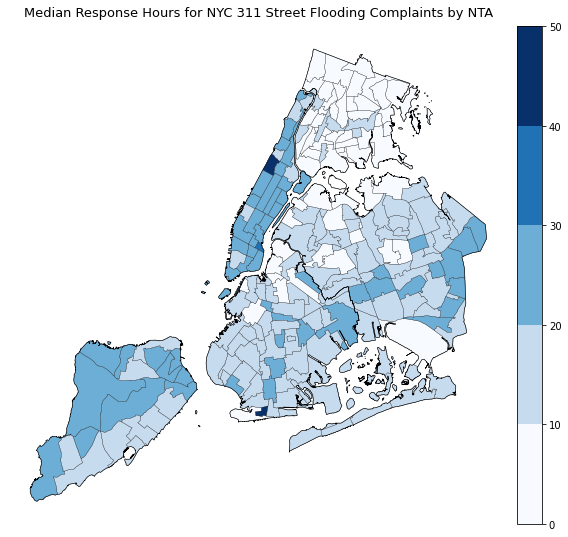

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.Blues
norm = mpl.colors.BoundaryNorm([0, 10, 20, 30, 40, 50], cmap.N)

nta_shape_time.plot(
    column='complaint_duration_hours', 
    cmap=cmap,
    ax=ax, 
    legend=True,
    cax=cax,
    norm=norm,
)

nta_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.2,
    ax=ax
)

borough_gdf.plot(
    facecolor="none", 
    edgecolor="black", 
    linewidth=.6,
    ax=ax
)

title = 'Median Response Hours for NYC 311 Street Flooding Complaints by NTA'
ax.set_title(title, fontsize=13, pad=10)

ax.axis('off')
plt.tight_layout()

# Bar Charts 
## Counts by Neighborhood Tabulation Areas (NTA)

In [43]:
nta_gdf_counts.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,ntaname_boro,shape_area_sq_mi,count,count_sq_mi
0,QN08,7.741275e+07,081,St. Albans,45401.316803,Queens,4,"MULTIPOLYGON (((1052996.196 196307.658, 105308...","St. Albans, Queens",2.776800,550,198
1,BX28,2.566612e+07,005,Van Cortlandt Village,21945.719299,Bronx,2,"MULTIPOLYGON (((1015481.837 261490.578, 101548...","Van Cortlandt Village, Bronx",0.920646,44,48
2,QN55,8.246139e+07,081,South Ozone Park,36708.169305,Queens,4,"MULTIPOLYGON (((1038120.503 188147.096, 103819...","South Ozone Park, Queens",2.957895,372,126
3,BK50,8.208968e+07,047,Canarsie,43703.609666,Brooklyn,3,"MULTIPOLYGON (((1015236.151 174910.303, 101523...","Canarsie, Brooklyn",2.944562,381,129
4,BX41,1.471671e+07,005,Mount Hope,18937.247819,Bronx,2,"MULTIPOLYGON (((1013128.525 250637.931, 101284...","Mount Hope, Bronx",0.527889,18,34


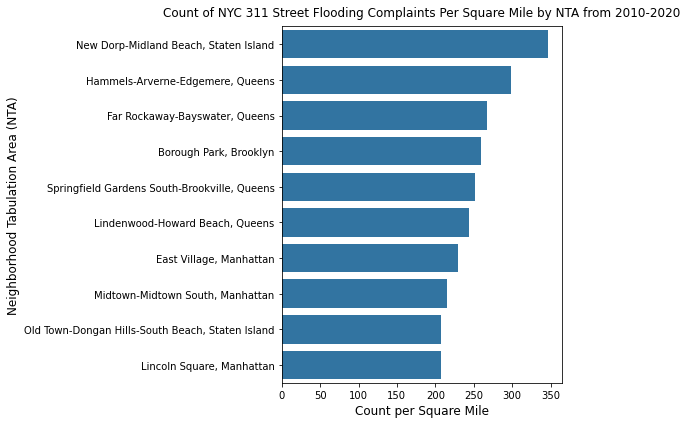

In [44]:
plt.figure(figsize=(8, 6))

data = nta_gdf_counts.sort_values(by='count_sq_mi', ascending=False).head(10)

sns.barplot(
    data=data,
    y='ntaname_boro',
    x='count_sq_mi',
    color='#1f77b4'
)

plt.title(
    'Count of NYC 311 Street Flooding Complaints Per Square Mile by NTA from 2010-2020',
    fontsize=12, pad=10)
plt.xlabel('Count per Square Mile', fontsize=12)
plt.ylabel('Neighborhood Tabulation Area (NTA)', fontsize=12)
plt.tight_layout()

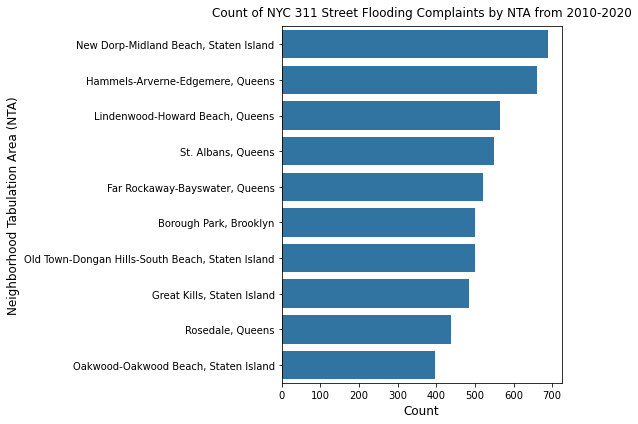

In [45]:
plt.figure(figsize=(8, 6))

data = nta_gdf_counts.sort_values(by='count', ascending=False).head(10)

sns.barplot(
    data=data,
    y='ntaname_boro',
    x='count',
    color='#1f77b4'
)

plt.title('Count of NYC 311 Street Flooding Complaints \
by NTA from 2010-2020', fontsize=12, pad=10)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Neighborhood Tabulation Area (NTA)', fontsize=12)
plt.tight_layout()